# Trenowanie metodą SVM i sieciami CNN

Projekt polega na porównaniu dwóch modeli uczenia maszynowego:
1. SVM trenowany dla **pełnych danych** i **wszystkich cech**.
1. Kilku sieci CNN składających się z **tej samej liczby neuronów** lecz różnej liczby warstw konwolucyjnych.

## 1. Zbióry danych treningowych

Przeprowadzenie porównania klasyfikatorów wykonamy na dwóch zbiorach: **MNIST** oraz **FMNIST**. Oba zbiory dostępne są między innymi w bibliotece *tensorflow* oraz *sklearn.datasets*.

### MNIST

8


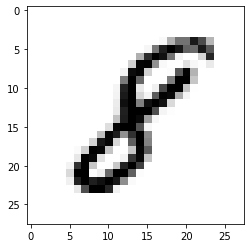

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
image_index = 7777 # You may select anything up to 70,000
print(y_train[image_index])
plt.imshow(x_train[image_index], cmap='Greys')

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

### FMNIST

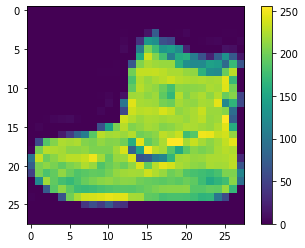

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [4]:
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)

## 2. Trenowanie i porównanie klasyfikatorów

### SVM

In [11]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

Ze względu **bardzo długi** czas uczenia metodą SVM na pełnym zbiorze - 70 000 obrazków (zbiory MNIST oraz FMNIST mają taką samą wielkość) - zdecydowaliśmy się na zmniejszenie zbioru o połowę - do 35 000. Taka decyzja wynikała z niemożliwości wykonania obliczeń dla pełnego zbioru. Gdy uruchomiłem uczenie SVM, po upływie 6h nadal nie uzysałem rezultatu. Złożoność czasowa dla SVM rośnie kwadratowo - przypuszczam, że na dokonanie pomiarów dla pełnego zbioru 70 000 elemntów i 10 cech potrzebowałbym więcej niż 12h obliczeń.

In [110]:
partmnist_data = mnist.data[0:10000]
partmnist_target = mnist.target[0:10000]

### Trenowanie klasyfikatora ze zbiorem testowym wynoszącym 25%

In [37]:
test_size = 0.25
x_mnist, y_mnist = partmnist_data, partmnist_target

x_train, x_test, y_train, y_test = train_test_split(x_mnist, y_mnist, test_size=test_size)

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_mnist = scaler.transform(x_mnist)

linear_svc = OneVsRestClassifier(svm.SVC(kernel="linear", C=0.1, probability=True)).fit(x_train, y_train)

### Krzywa ROC klasyfikatora

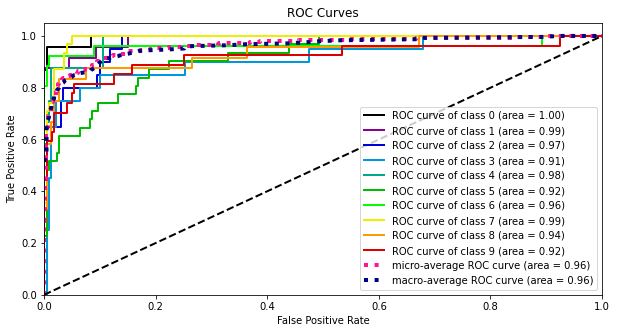

In [80]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_predicted = linear_svc.predict_proba(x_test)
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 10
skplt.metrics.plot_roc(y_test, y_predicted)
plt.show()

### Krzywa Precision-Recall klasyfikatora

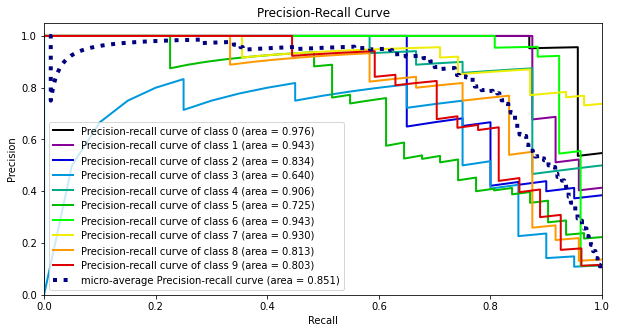

In [81]:
y_predicted = linear_svc.predict_proba(x_test)
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 10
skplt.metrics.plot_precision_recall(y_test, y_predicted)
plt.show()

### Wyniki jakości klasyfikatora

In [108]:
def show_res(test_data, test_label):
    y_predicted = linear_svc.predict(test_data)
    y_predicted_proba = linear_svc.predict_proba(test_data)
    print("Accuracy score:", metrics.accuracy_score(test_label, y_predicted))
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - -")
    print("Loss:", metrics.hinge_loss(test_label, y_predicted_proba))
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - -")
    print("Średnia ważona Precision-Recall dla każdej kategorii")
    f1_score = metrics.f1_score(test_label, y_predicted, average = None)
    for i, res in enumerate(f1_score):
        print("klasa",  i, ":", res)
        
show_res(x_test, y_test)

Accuracy score: 0.796
- - - - - - - - - - - - - - - - - - - - - - - - - - -
Loss: 0.5289620164861977
- - - - - - - - - - - - - - - - - - - - - - - - - - -
Średnia ważona Precision-Recall dla każdej kategorii
klasa 0 : 0.8979591836734695
klasa 1 : 0.8076923076923077
klasa 2 : 0.6666666666666667
klasa 3 : 0.7027027027027027
klasa 4 : 0.8571428571428572
klasa 5 : 0.6785714285714285
klasa 6 : 0.9019607843137256
klasa 7 : 0.8615384615384616
klasa 8 : 0.8
klasa 9 : 0.7307692307692308


Ocena jakości klasyfikatorów w zależności od **ilości przykładów uczącyc** - parametr *test_size*

In [109]:
def compare_SVM(test_size):
    x_mnist, y_mnist = partmnist_data, partmnist_target
    x_train, x_test, y_train, y_test = train_test_split(x_mnist, y_mnist, test_size=test_size)
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    x_mnist = scaler.transform(x_mnist)
    linear_svc = OneVsRestClassifier(svm.SVC(kernel="linear", C=0.1, probability=True)).fit(x_train, y_train)
    print("=====================================================")
    print("Test_size:", test_size)
    print("=====================================================")
    show_res(x_test, y_test)
    
test_size_sample = [0.25, 0.4, 0.55, 0.7]
for test_size in test_size_sample:
    compare_SVM(test_size)

Test_size: 0.25
Accuracy score: 0.94
- - - - - - - - - - - - - - - - - - - - - - - - - - -
Loss: 0.266472109274595
- - - - - - - - - - - - - - - - - - - - - - - - - - -
Średnia ważona Precision-Recall dla każdej kategorii
klasa 0 : 0.9615384615384616
klasa 1 : 0.955223880597015
klasa 2 : 0.9310344827586207
klasa 3 : 0.9199999999999999
klasa 4 : 1.0
klasa 5 : 0.8648648648648649
klasa 6 : 0.9803921568627451
klasa 7 : 0.9056603773584906
klasa 8 : 0.962962962962963
klasa 9 : 0.9152542372881356
Test_size: 0.4
Accuracy score: 0.945
- - - - - - - - - - - - - - - - - - - - - - - - - - -
Loss: 0.2544158459391868
- - - - - - - - - - - - - - - - - - - - - - - - - - -
Średnia ważona Precision-Recall dla każdej kategorii
klasa 0 : 0.9705882352941176
klasa 1 : 0.9555555555555556
klasa 2 : 0.9397590361445782
klasa 3 : 0.9090909090909091
klasa 4 : 0.968421052631579
klasa 5 : 0.8705882352941177
klasa 6 : 0.988235294117647
klasa 7 : 0.9655172413793104
klasa 8 : 0.9285714285714286
klasa 9 : 0.94594594594

### CNN

clothes dataset

In [16]:
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential

# Preparing the dataset
# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) 
x_test = x_test.reshape(x_test.shape[0], image_size)

# Convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
model = Sequential()


def create_dense(layer_sizes):
    model = Sequential()
    model.add(Dense(layer_sizes[0], activation='sigmoid', input_shape=(image_size,)))

    # The input layer requires the special input_shape parameter which should match
    # the shape of our training data.
    for s in layer_sizes[1:]:
        model.add(Dense(units = s, activation = 'sigmoid'))

    model.add(Dense(units=num_classes, activation='softmax'))

    return model

def evaluate(model):
    model.summary()
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=16, epochs=30, validation_split=.1, verbose=False)
    loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

    print()
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')
    
    
for layers in range(1, 10):
    model = create_dense([32] * layers)
    evaluate(model)  

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_100 (Dense)            (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________

Test loss: 0.345
Test accuracy: 0.899
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_102 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_103 (Dense)            (None, 10)              

KeyboardInterrupt: 